In [19]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [20]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

In [21]:
for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/32x32/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/32x32/train_attack/train_attack_equ_*.jpg', recursive=True):
    train_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/32x32/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for i in glob.glob('/Users/ryan/NSL CNN/2d-cnn/32x32/test_attack/test_attack_equ_*.jpg', recursive=True):
    test_attack.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

train_normal = np.stack(train_normal)
train_attack = np.stack(train_attack)
test_normal = np.stack(test_normal)
test_attack = np.stack(test_attack)

In [22]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack),

((7496, 32, 32), (6510, 32, 32), (1082, 32, 32), (1427, 32, 32))

In [23]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


train = np.vstack((train_normal, train_attack, vert_flip_train_attack, vert_flip_train_normal, hor_flip_train_attack, hor_flip_train_normal,rotate90l_train_attack, rotate90r_train_attack, rotate90r_train_normal, rotate90l_train_normal))

test = np.vstack((test_normal, test_attack, vert_flip_test_attack, vert_flip_test_normal, hor_flip_test_attack, hor_flip_test_normal,rotate90l_test_attack, rotate90r_test_attack, rotate90l_test_normal, rotate90r_test_normal))

In [5]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_attack))
test = np.vstack((test_normal, test_attack))

In [24]:
train.shape, test.shape

((70030, 32, 32), (12545, 32, 32))

In [25]:
train = train.reshape(-1,32,32,1)
test = test.reshape(-1,32,32,1)

In [26]:
train.shape, test.shape

((70030, 32, 32, 1), (12545, 32, 32, 1))

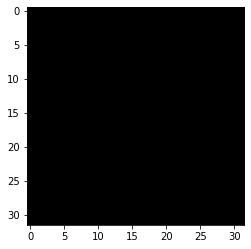

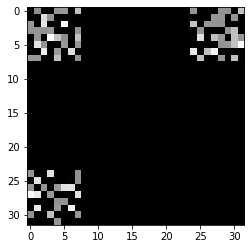

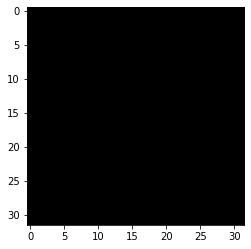

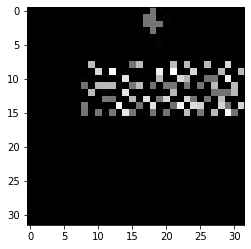

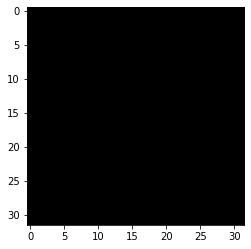

In [27]:
for i in range(0, 5):
    plt.imshow(train[i], cmap = 'gray')
    plt.show()

In [9]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [28]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [29]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 70025       0       1
 70026       0       1
 70027       0       1
 70028       0       1
 70029       0       1
 
 [70030 rows x 2 columns],
        attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 12540       0       1
 12541       0       1
 12542       0       1
 12543       0       1
 12544       0       1
 
 [12545 rows x 2 columns])

In [30]:
## shuffle the data to prevent pattern recognition
train = sklearn.utils.shuffle(train, random_state = 7)
ytrain = sklearn.utils.shuffle(ytrain, random_state = 7)

test = sklearn.utils.shuffle(test, random_state = 7)
ytest = sklearn.utils.shuffle(ytest, random_state = 7)

In [42]:
cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(4, (2,2), padding="same", activation='relu', input_shape = (32,32,1)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 2
cnn.add(Convolution2D(8, (2,2), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 3
# cnn.add(Convolution2D(64, (4,4), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 4
# cnn.add(Convolution2D(128, (4,4), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.8))

## convolution 6
# cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
# cnn.add(MaxPooling2D(pool_size = (1,1)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
cnn.add(Dense(8, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 4)         68        
_________________________________________________________________
average_pooling2d_12 (Averag (None, 16, 16, 4)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 8)         520       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 8, 8, 8)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

In [43]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 256, epochs = 200)
end = time.time()

os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/200
274/274 [==============================] - 7s 24ms/step - loss: 1.0631 - accuracy: 0.5253
Epoch 2/200
274/274 [==============================] - 6s 24ms/step - loss: 0.6503 - accuracy: 0.6068
Epoch 3/200
274/274 [==============================] - 6s 24ms/step - loss: 0.5958 - accuracy: 0.6550
Epoch 4/200
274/274 [==============================] - 7s 24ms/step - loss: 0.5580 - accuracy: 0.6848
Epoch 5/200
274/274 [==============================] - 7s 24ms/step - loss: 0.5399 - accuracy: 0.6961
Epoch 6/200
274/274 [==============================] - 7s 24ms/step - loss: 0.5185 - accuracy: 0.7100
Epoch 7/200
274/274 [==============================] - 7s 25ms/step - loss: 0.5050 - accuracy: 0.7207
Epoch 8/200
274/274 [==============================] - 7s 26ms/step - loss: 0.4832 - accuracy: 0.7333
Epoch 9/200
274/274 [==============================] - 7s 26ms/step - loss: 0.4643 - accuracy: 0.7406
Epoch 10/200
274/274 [==============================] - 7s 27ms/step - loss: 0.443

dict_keys(['loss', 'accuracy'])


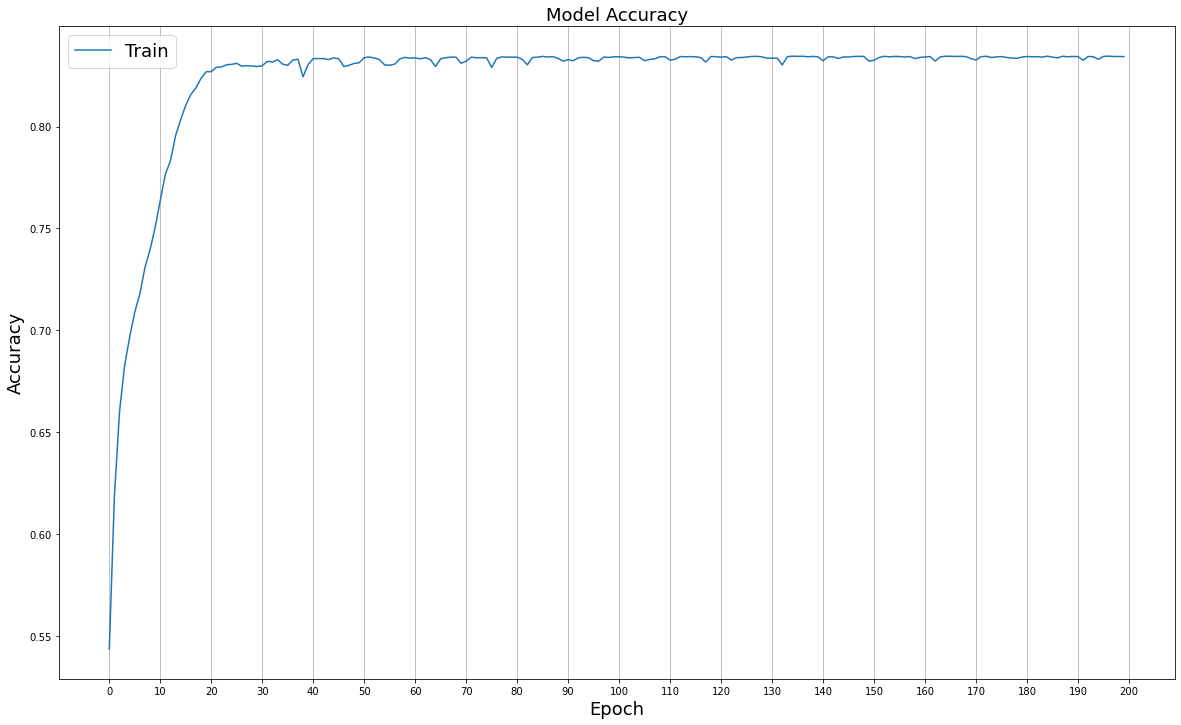

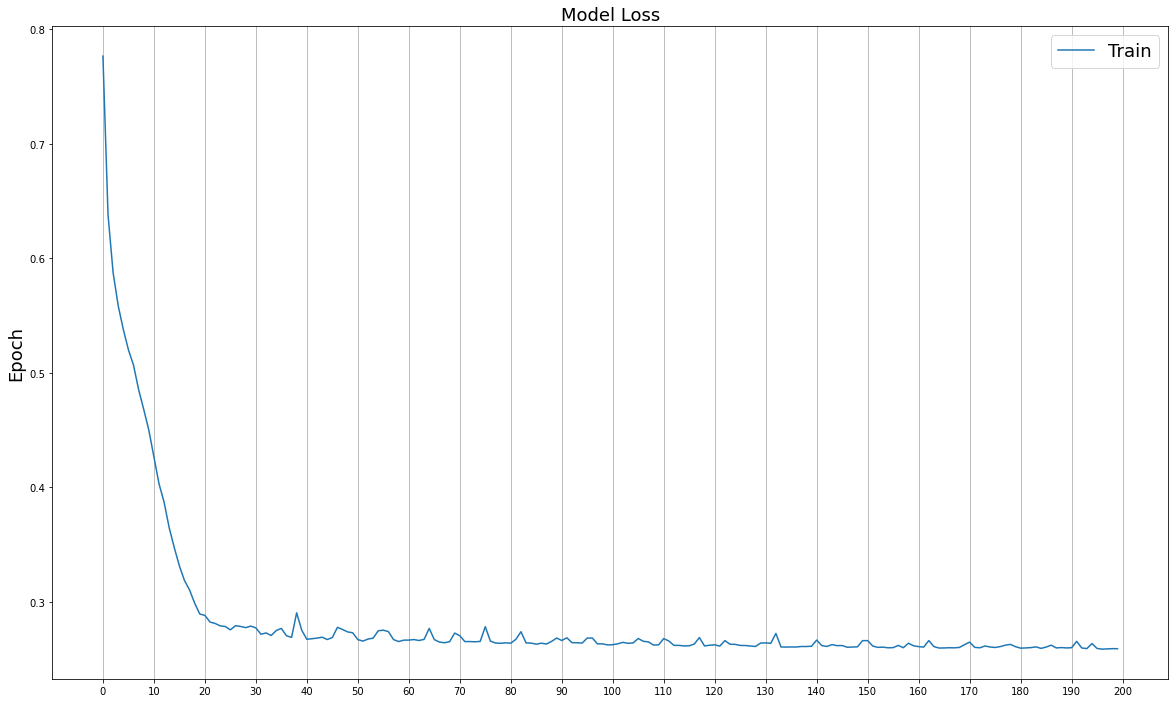

In [44]:
print(model_history.history.keys())

figure(figsize = (20,12))
plt.plot(model_history.history['accuracy'])
# plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10))
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

figure(figsize = (20,12))
plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 210, step = 10), )
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

In [45]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 200, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.4576	Accuracy = 64.94%


In [46]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.44102, 0.55898],
       [0.44102, 0.55898],
       [0.44102, 0.55898],
       [1.     , 0.     ],
       [0.11774, 0.88227],
       [0.44102, 0.55898],
       [0.44102, 0.55898],
       [0.     , 1.     ],
       [0.44102, 0.55898],
       [0.44102, 0.55898],
       [0.89399, 0.106  ],
       [0.54435, 0.45564],
       [0.00001, 0.99999],
       [0.00247, 0.99753],
       [0.44102, 0.55898],
       [0.99215, 0.0079 ],
       [0.44102, 0.55898],
       [0.44102, 0.55898],
       [1.     , 0.     ],
       [0.00174, 0.99826]], dtype=float32)

In [36]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (2,2), padding="same", activation='relu', input_shape = (32,32,1)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (2,2), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (2,2), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (2,2), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(256, (3,3), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 6
    # cnn.add(Convolution2D(512, (2,2), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (1,1)))
    # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 256, epochs = 200)

In [37]:
scores = cross_val_score(estimator = classifier, X = test, y = ytest, cv = 10, n_jobs = -1)
print(f'Model Cross Validation: \n{round(scores.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{scores}')

os.system('say "cross validation finished" ')

Model Cross Validation: 
76.6%
Model Cross Validation: 
[0.75538 0.75139 0.7761  0.76016 0.76813 0.7815  0.76396 0.78389 0.76156
 0.76236]


0